In [39]:
import pandas as pd
import numpy as np
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import  accuracy_score
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [40]:
train=pd.read_csv('train.csv', index_col=0)
test=pd.read_csv('test.csv', index_col=0)
submit=pd.read_csv('submit.csv', index_col=0)

## Разведочный анализ

In [41]:
# число дубликатов в датасете train и test
print(train.duplicated().sum())
print(test.duplicated().sum())

2346
505


In [42]:
# удаляем дубликаты
train = train.drop_duplicates()
test = test.drop_duplicates()

In [43]:
train['ts']=pd.to_datetime(train['ts'])
test['ts']=pd.to_datetime(test['ts'])
train['date']=train['ts'].dt.date
test['date']=test['ts'].dt.date

In [44]:
# распределение по user_id
train.user_id.value_counts()

37    2184
55    2166
6     1857
12    1837
19    1661
15    1659
18    1441
53    1279
11    1255
47    1250
33    1184
0     1184
1     1171
49    1129
39    1032
32    1020
9     1015
54     977
50     965
29     924
3      894
48     712
17     648
14     617
35     549
27     523
57     482
46     475
24     386
42     340
26     279
34     267
23     247
40     242
25     238
31     181
56     129
43     117
20     112
41     110
22      87
28      64
45      57
7       48
36      45
2       39
8       27
10      17
38      13
5       10
30      10
52       5
21       5
44       4
51       2
4        1
Name: user_id, dtype: int64

In [45]:
grp_user = train.groupby('user_id').agg(
    counts=('ts', 'count'),
    date_unique=('date', lambda x: x.nunique()))
grp_user.sort_values(['counts']).head(7)

,counts,date_unique
user_id,,
4,1,1
51,2,2
44,4,1
21,5,2
52,5,1
30,10,2
5,10,2


In [46]:
# Фильтрация данных, исключая пользователей из списка user_id_to_delete
user_id_to_delete=[4, 51, 44, 21, 52] #можно удалить
train = train[~train['user_id'].isin(user_id_to_delete)]

In [47]:
# вычислим уникальные gate_id в train и количество пересечений через каждый турникет
train_gate = train['gate_id'].value_counts(dropna = False).sort_index()
train_gate
#gate_id_to_delete = [0,1,14,16] вероятно можно удалить

-1       25
 0        2
 1        5
 3     5219
 4     7976
 5     4548
 6     1739
 7     3025
 8       23
 9     1728
 10    4767
 11    4090
 12     619
 13    1087
 14       1
 15     298
 16       3
Name: gate_id, dtype: int64

In [48]:
# вычислим уникальные gate_id в test и количество пересечений через каждый турникет
test_gate = test['gate_id'].value_counts(dropna = False).sort_index()
test_gate
#gate_id_to_delete = [-1,1,2,14] вероятно можно удалить

-1        1
 1        2
 2        4
 3      893
 4     1431
 5      853
 6      282
 7      540
 8       10
 9      394
 10     915
 11     762
 12     120
 13     310
 14       1
 15     102
Name: gate_id, dtype: int64

In [49]:
only_train = set(train['gate_id']) - set(test['gate_id'])
only_test = set(test['gate_id']) - set(train['gate_id'])
print("Каких gate_id из train нет в test:", only_train)
print("Каких gate_id из test нет в train: ", only_test)

Каких gate_id из train нет в test: {0, 16}
Каких gate_id из test нет в train:  {2}


Так как турникетов 0, 16 нет в тесте, их нет необходимости распознавать, можно удалить. В трейне они встречаются соответственно 2 и 3 раза.
Пользователи с номером -1,1,2,14 встречаются 4 и менее раз в test, их будет довольно сложно распознать. Необходимо либо аугментировать данные, либо удалить.
Записей о пользователях с номерами 0,1,14,16 мало, для лучшей работы модели их можно удалить


In [50]:
def del_gate(data, number_list):
    return data[~data['gate_id'].isin(number_list)]
list_gate_id_del = [-1, 0, 1, 2, 14, 16] #[0, 16] # 
train = del_gate(train, list_gate_id_del)
test=del_gate(test, list_gate_id_del)

# Feature engineering

In [51]:
test.rename(columns={'user_word': 'user_id'}, inplace=True)

In [52]:
def process_data(df):
    #метки времени
    df['ts'] = pd.to_datetime(df['ts'])
    df['day'] = df['ts'].dt.day
    df['hour'] = df['ts'].dt.hour
    df['minute'] = df['ts'].dt.minute
    df["second"] = df['ts'].dt.second #на обучении удаляется
    df['minutes'] = df["hour"] * 60 + df["minute"] 
    df['seconds'] = df.minutes * 60 + df["second"]
    
    #метки дней  
    df["weekday"] = df['ts'].dt.dayofweek                  # День недели от 0 до 6
    df["Dow2"] = (df['ts'].dt.dayofyear % 4).apply(lambda x: int(x in (1, 2))) #график работы 2 через 2 
    df["Dow2_2"] = (df['ts'].dt.dayofyear % 4).apply(lambda x: int(x < 2)) #второй график такой же со сдвигом на 1
    
    # Длина рабочего дня, количество проходов за день у каждого пользователя
    df.sort_values(['user_id', 'ts'], inplace=True)
    df['date'] = df['ts'].dt.date
    first_entry_exit_per_day = df.groupby(['user_id', 'date'], as_index=False)['ts'].agg(['min', 'max']).reset_index()
    first_entry_exit_per_day['time_diff'] = (first_entry_exit_per_day['max'] - first_entry_exit_per_day['min']).dt.total_seconds() / 60
    first_entry_exit_per_day['count'] = df.groupby(['user_id', 'date']).count()['ts'].reset_index(name='count')['count']
    df = pd.merge(df, first_entry_exit_per_day[['user_id', 'date', 'time_diff', 'count']], on=['user_id', 'date'], how='left')

    #Первый и последний турникеты для каждой группы
    grouped_data = df.groupby(['user_id', 'date'])
    first_gate = grouped_data['gate_id'].first().reset_index()
    last_gate = grouped_data['gate_id'].last().reset_index()
    df = pd.merge(df, first_gate, on=['user_id', 'date'], how='left', suffixes=('', '_first'))
    df = pd.merge(df, last_gate, on=['user_id', 'date'], how='left', suffixes=('', '_last'))

    #Вероятность попадания гейта
    gate_counts = df.groupby(['user_id', 'gate_id'])['user_id'].count().reset_index(name='gate_count')
    gate_counts['gate_prob'] = gate_counts.groupby('user_id')['gate_count'].transform(lambda x: np.exp(x) / np.exp(x).sum())
    df = pd.merge(df, gate_counts[['user_id', 'gate_id', 'gate_prob']], on=['user_id', 'gate_id'], how='left')

    return df
train = process_data(train)
test = process_data(test)

In [53]:
test.rename(columns={'user_id': 'user_word'}, inplace=True)

Я не успела красиво оформить ниже, добавляю сдвиги по турникетам и сдвиги по времени прохождения турникетов в течении дня по каждому пользователю.

In [54]:
train.sort_values(['user_id', 'ts'], inplace=True)
grouped_data = train.groupby(['user_id', 'date'])
train['g1'] = grouped_data['gate_id'].shift(-1)
train['g-1'] = grouped_data['gate_id'].shift(1)
train['g2'] = grouped_data['gate_id'].shift(-2)
train['g-2'] = grouped_data['gate_id'].shift(2)
train['g3'] = grouped_data['gate_id'].shift(-3)
train['g-3'] = grouped_data['gate_id'].shift(3)
train['g4'] = grouped_data['gate_id'].shift(-4)
train['g-4'] = grouped_data['gate_id'].shift(4)
train['g5'] = grouped_data['gate_id'].shift(-5)
train['g-5'] = grouped_data['gate_id'].shift(5)

train['g-1'].fillna(-1000, inplace=True)
train['g-2'].fillna(-1000, inplace=True)
train['g-3'].fillna(-1000, inplace=True)
train['g-4'].fillna(-1000, inplace=True)
train['g-5'].fillna(-1000, inplace=True)
train['g1'].fillna(-900, inplace=True)
train['g2'].fillna(-900, inplace=True)
train['g3'].fillna(-900, inplace=True)
train['g4'].fillna(-900, inplace=True)
train['g5'].fillna(-900, inplace=True)

test.sort_values(['user_word', 'ts'], inplace=True)
grouped_data = test.groupby(['user_word', 'date'])
test['g1'] = grouped_data['gate_id'].shift(-1)
test['g-1'] = grouped_data['gate_id'].shift(1)
test['g2'] = grouped_data['gate_id'].shift(-2)
test['g-2'] = grouped_data['gate_id'].shift(2)
test['g3'] = grouped_data['gate_id'].shift(-3)
test['g-3'] = grouped_data['gate_id'].shift(3)
test['g4'] = grouped_data['gate_id'].shift(-4)
test['g-4'] = grouped_data['gate_id'].shift(4)
test['g5'] = grouped_data['gate_id'].shift(-5)
test['g-5'] = grouped_data['gate_id'].shift(5)

test['g-1'].fillna(-1000, inplace=True)
test['g-2'].fillna(-1000, inplace=True)
test['g-3'].fillna(-1000, inplace=True)
test['g-4'].fillna(-1000, inplace=True)
test['g-5'].fillna(-1000, inplace=True)
test['g1'].fillna(-900, inplace=True)
test['g2'].fillna(-900, inplace=True)
test['g3'].fillna(-900, inplace=True)
test['g4'].fillna(-900, inplace=True)
test['g5'].fillna(-900, inplace=True)

train.sort_values(['user_id', 'ts'], inplace=True)
grouped_data = train.groupby(['user_id', 'date'])
train['delta_sec-1'] = grouped_data['seconds'].shift(periods=-1, fill_value=-200) - train['seconds']
train['delta_sec-2'] = grouped_data['seconds'].shift(periods=-2, fill_value=-200) - train['seconds']
train['delta_sec-3'] = grouped_data['seconds'].shift(periods=-3, fill_value=-200) - train['seconds']
train['delta_sec-4'] = grouped_data['seconds'].shift(periods=-4, fill_value=-200) - train['seconds']
train['delta_sec-5'] = grouped_data['seconds'].shift(periods=-5, fill_value=-200) - train['seconds']

train['delta_sec1'] = grouped_data['seconds'].shift(periods=1, fill_value=200) - train['seconds']
train['delta_sec2'] = grouped_data['seconds'].shift(periods=2, fill_value=200) - train['seconds']
train['delta_sec3'] = grouped_data['seconds'].shift(periods=3, fill_value=200) - train['seconds']
train['delta_sec4'] = grouped_data['seconds'].shift(periods=4, fill_value=200) - train['seconds']
train['delta_sec5'] = grouped_data['seconds'].shift(periods=5, fill_value=200) - train['seconds']

test.sort_values(['user_word', 'ts'], inplace=True)
grouped_data = test.groupby(['user_word', 'date'])
test['delta_sec-1'] = grouped_data['seconds'].shift(periods=-1, fill_value=-200) - test['seconds']
test['delta_sec-2'] = grouped_data['seconds'].shift(periods=-2, fill_value=-200) - test['seconds']
test['delta_sec-3'] = grouped_data['seconds'].shift(periods=-3, fill_value=-200) - test['seconds']
test['delta_sec-4'] = grouped_data['seconds'].shift(periods=-4, fill_value=-200) - test['seconds']
test['delta_sec-5'] = grouped_data['seconds'].shift(periods=-5, fill_value=-200) - test['seconds']

test['delta_sec1'] = grouped_data['seconds'].shift(periods=1, fill_value=200) - test['seconds']
test['delta_sec2'] = grouped_data['seconds'].shift(periods=2, fill_value=200) - test['seconds']
test['delta_sec3'] = grouped_data['seconds'].shift(periods=3, fill_value=200) - test['seconds']
test['delta_sec4'] = grouped_data['seconds'].shift(periods=4, fill_value=200) - test['seconds']
test['delta_sec5'] = grouped_data['seconds'].shift(periods=5, fill_value=200) - test['seconds']

In [55]:
# Инициализация модели и обучение на обучающей выборке
X_train = train.drop(columns=['user_id','ts', 'date','second'])
y_train = train['user_id']

In [56]:
# train.sort_values(['ts'], inplace=True)
# tscv = TimeSeriesSplit(n_splits=4)
# # Инициализация модели и параметров для поиска
# clf = RandomForestClassifier(random_state=1)
# param_grid = {
#     'n_estimators': [50, 100, 200],
#     'max_features': ['sqrt', 'log2'],
#     "max_depth": [10, 15, 20, 50],
#     'criterion': ['gini', 'entropy']}

In [57]:
# #Инициализация GridSearchCV
# grid_RF = GridSearchCV(clf, param_grid, scoring='accuracy', verbose=2, cv=tscv)
# grid_RF.fit(X_train, y_train)

In [58]:
# grid_RF.best_params_

#grid_RF.best_params_
{'criterion': 'gini',
 'max_depth': 20,
 'max_features': 'log2',
 'n_estimators': 50}

In [59]:
clf = RandomForestClassifier(criterion='gini', max_depth=50,  max_features='log2', n_estimators=50, random_state=1)
clf.fit(X_train, y_train)

RandomForestClassifier(max_depth=50, max_features='log2', n_estimators=50,
                       random_state=1)

In [60]:
y_train_pred = clf.predict(X_train)

In [61]:
# Предсказание на тестовой выборке
X_test = test.drop(columns=['ts','user_word', 'date', 'second'])
y_test_pred = clf.predict(X_test)
test['predicted_user_id'] = y_test_pred

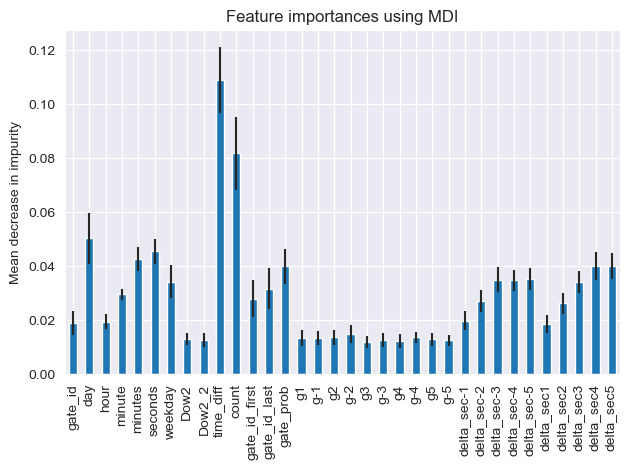

In [62]:
importances = clf.feature_importances_
std = np.std([tree.feature_importances_ for tree in clf.estimators_], axis=0)
forest_importances = pd.Series(importances, index=X_test.columns)
fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

Вывод user_id как самого частотного предсказанного значения для user_word - 
user_id могут повторяться, не самое точное предсказание

In [63]:
final = test.groupby('user_word')['predicted_user_id'].agg(lambda x: x.value_counts().idxmax()).reset_index(name='preds')
final=final.set_index('user_word')
final.shape[0]
final.rename(columns={"user_word" : "word"},inplace=True)

Сопоставление user_id и user_word по вероятности попадания (по доле количества предсказаний конкретного user_id в количестве всех предсказанных значений). Вероятность сортировалась по убыванию и последовательно выбирался user_id с максимальным значением вероятности. Если такое значение уже занято, то берется следующее вероятное.

In [64]:
# Рассчитать вероятности попадания для каждого user_word_id
grouped_sum = test.groupby(['user_word', 'predicted_user_id']).size().reset_index(name='count_sum')
total_sum = test.groupby('user_word').size().reset_index(name='total_sum')
result_probabilities = pd.merge(grouped_sum, total_sum, on='user_word')
result_probabilities['probability'] = result_probabilities['count_sum'] / result_probabilities['total_sum']
sorted_probabilities = result_probabilities.sort_values(by='probability', ascending=False)
sorted_probabilities2 = result_probabilities.sort_values(by=['user_word','probability',], ascending=False)

In [65]:
# Создать таблицу сопоставления word и preds
word_preds_mapping = pd.DataFrame(columns=['word', 'preds'])
used_words = set()
used_preds = set()
order_list = []
for index, row in sorted_probabilities.iterrows():
    if row['user_word'] not in used_words and row['predicted_user_id'] not in used_preds:
        word_preds_mapping = word_preds_mapping.append({'word': row['user_word'], 'preds': row['predicted_user_id']}, ignore_index=True)
        used_words.add(row['user_word'])
        used_preds.add(row['predicted_user_id'])
        order_list.append(row['user_word'])

Дополнение: если для определенного user_word не хватило значения, использовать -999.
В данном случае не хватило предсказания для regression, для него выставляется -999

In [66]:
for index, row in sorted_probabilities.iterrows():
    if row['user_word'] not in used_words:
        word_preds_mapping = word_preds_mapping.append({'word': row['user_word'], 'preds': -999}, ignore_index=True)
        used_words.add(row['user_word'])
        used_preds.add(row['predicted_user_id'])

На протяжении многих попыток загрузки сабмита выяснилось что 'y' - тоже новый пользователь, поэтому выставляю для него -999

In [67]:
word_preds_mapping.loc[word_preds_mapping['word'] == 'y', 'preds'] = -999

In [68]:
word_preds_mapping=word_preds_mapping.set_index('word')
word_preds_mapping = word_preds_mapping.sort_values(by='word')
word_preds_mapping.shape[0]
word_preds_mapping.to_csv('answer.csv')

### Приложение. Фичи, которые убавляли скор

In [69]:
#test.rename(columns={'user_word': 'user_id'}, inplace=True)
# def process_data(df):
#     метки времени
#     df['ts'] = pd.to_datetime(df['ts'])
#     df["second"] = df['ts'].dt.second
#     df["is_weekend"] = df["weekday"].map(lambda x: 1 if x in (5, 6) else 0)  # Метка выходного дня
#     #метки дней
#     df["1day"] = df['ts'].dt.is_month_start.astype(int)     # 1-й день месяца
#     df["2day"] = (df.day == 2).astype(int)                  # 2-й день месяца
#     df["last_day-1"] = (df.day == df.ts.dt.daysinmonth-1).astype(int) # Предпоследний день месяца
#     df["last_day"] = df['ts'].dt.is_month_end.astype(int)  # Последний день месяца
# 
#     # Метки времени суток
#     df['morning'] = df['hour'].map(lambda x: 1 if 6 <= x < 12 else 0) 
#     df['daytime'] = df['hour'].map(lambda x: 1 if 12 <= x < 18 else 0)
#     df['evening'] = df['hour'].map(lambda x: 1 if 18 <= x < 24 else 0)
#     df['lunch_break'] = df['hour'].map(lambda x: 1 if 12 <= x < 14 else 0)
# 
#     # Вероятность прохождения пользователем гейта
#     gate_counts['user_prob'] = gate_counts.groupby('gate_id')['gate_count'].transform(lambda x: np.exp(x)/np.exp(x).sum())
#     df = pd.merge(df, gate_counts[['user_id', 'gate_id', 'user_prob']], on=['user_id', 'gate_id'], how='left')
#     
#     return df
# train = process_data(train)
# test = process_data(test)
#test.rename(columns={'user_id': 'user_word'}, inplace=True)

Время входа выхода в часах

In [70]:
#train['entry_time'] = train.groupby(['user_id', 'date'])['ts'].transform('min')
#train['exit_time'] = train.groupby(['user_id', 'date'])['ts'].transform('max')
#train['entry_hour'] = (train['ts'] - train['entry_time']).dt.total_seconds() / 3600
#train['exit_hour'] = (train['ts'] - train['exit_time']).dt.total_seconds() / 3600
#train.drop(['entry_time', 'exit_time'], axis=1, inplace=True)

#test['entry_time'] = test.groupby(['user_word', 'date'])['ts'].transform('min')
#test['exit_time'] = test.groupby(['user_word', 'date'])['ts'].transform('max')
#test['entry_hour'] = (test['ts'] - test['entry_time']).dt.total_seconds() / 3600
#test['exit_hour'] = (test['ts'] - test['exit_time']).dt.total_seconds() / 3600
#test.drop(['entry_time', 'exit_time'], axis=1, inplace=True)

Метка 2 одинаковых гейта подряд и разница между ними 20 минут и меньше

In [71]:
#train.sort_values(['user_id', 'ts'], inplace=True)
#grouped_data = train.groupby('user_id')
#train['same_turnstile_within_20min'] = 0
#train['time_diff2'] = train.groupby('user_id')['ts'].diff()
#condition = ((train['time_diff2'] <= timedelta(minutes=20)) & (train['gate_id'] == train['gate_id'].shift(1)))|((train['time_diff2'].shift(1) <= timedelta(minutes=20)) &(train['gate_id'] == train['gate_id'].shift(-1)))
#train.loc[condition, 'same_turnstile_within_20min'] = 1
#train.drop('time_diff2', axis=1, inplace=True)

#test.sort_values(['user_word', 'ts'], inplace=True)
#grouped_data = test.groupby('user_word')
#test['same_turnstile_within_20min'] = 0
#test['time_diff2'] = test.groupby('user_word')['ts'].diff()
#condition = ((test['time_diff2'] <= timedelta(minutes=20)) & (test['gate_id'] == test['gate_id'].shift(1)))|((test['time_diff2'].shift(1) <= timedelta(minutes=20)) &(test['gate_id'] == test['gate_id'].shift(-1)))
#test.loc[condition, 'same_turnstile_within_20min'] = 1
#test.drop('time_diff2', axis=1, inplace=True)

Самый встречающийся турникет для каждой группы - по дням и за все время

In [72]:
# most_frequent_gate_daily = grouped_data['gate_id'].agg(lambda x: x.value_counts().idxmax()).reset_index()
# most_frequent_gate_total = train.groupby('user_id')['gate_id'].agg(lambda x: x.value_counts().idxmax()).reset_index()
# train = pd.merge(train, most_frequent_gate_daily, on=['user_id', 'date'], how='left', suffixes=('', '_most_frequent_daily'))
# train = pd.merge(train, most_frequent_gate_total, on='user_id', how='left', suffixes=('', '_most_frequent_total'))

# most_frequent_gate_daily = grouped_data['gate_id'].agg(lambda x: x.value_counts().idxmax()).reset_index()
# most_frequent_gate_total = test.groupby('user_word')['gate_id'].agg(lambda x: x.value_counts().idxmax()).reset_index()
# test = pd.merge(test, most_frequent_gate_daily, on=['user_word', 'date'], how='left', suffixes=('', '_most_frequent_daily'))
# test = pd.merge(test, most_frequent_gate_total, on='user_word', how='left', suffixes=('', '_most_frequent_total'))

Самый встречающийся турникет для входа и выхода для каждого пользователя

In [73]:
# most_common_entry_gate = first_gate.groupby('user_id')['gate_id'].agg(lambda x: x.value_counts().idxmax()).reset_index()
# most_common_entry_gate.columns = ['user_id', 'most_common_entry_gate']
# most_common_exit_gate = last_gate.groupby('user_id')['gate_id'].agg(lambda x: x.value_counts().idxmax()).reset_index()
# most_common_exit_gate.columns = ['user_id', 'most_common_exit_gate']
# train = pd.merge(train, most_common_entry_gate, on='user_id', how='left')
# train = pd.merge(train, most_common_exit_gate, on='user_id', how='left')

# most_common_entry_gate = first_gate.groupby('user_word')['gate_id'].agg(lambda x: x.value_counts().idxmax()).reset_index()
# most_common_entry_gate.columns = ['user_word', 'most_common_entry_gate']
# most_common_exit_gate = last_gate.groupby('user_word')['gate_id'].agg(lambda x: x.value_counts().idxmax()).reset_index()
# most_common_exit_gate.columns = ['user_word', 'most_common_exit_gate']
# test = pd.merge(test, most_common_entry_gate, on='user_word', how='left')
# test = pd.merge(test, most_common_exit_gate, on='user_word', how='left')

Самый встречающийся гейт за неделю для каждого пользователя и самый встречающийся по дням недели

In [74]:
# train['week'] = train['ts'].dt.strftime('%Y-%U')
# most_frequent_gate_weekly = train.groupby(['user_id', 'week'])['gate_id'].agg(lambda x: x.value_counts().idxmax()).reset_index()
# most_frequent_gate_weekly.columns = ['user_id', 'week', 'most_frequent_gate_weekly']
# train = pd.merge(train, most_frequent_gate_weekly, on=['user_id', 'week'], how='left')
# train = train.drop(columns=['week'])
# most_frequent_gate_weekday = train.groupby(['user_id', 'weekday'])['gate_id'].agg(lambda x: x.value_counts().idxmax()).reset_index()
# most_frequent_gate_weekday.columns = ['user_id', 'weekday', 'most_frequent_gate_weekday']
# train = pd.merge(train, most_frequent_gate_weekday, on=['user_id', 'weekday'], how='left')

# test['week'] = test['ts'].dt.strftime('%Y-%U')
# most_frequent_gate_weekly = test.groupby(['user_word', 'week'])['gate_id'].agg(lambda x: x.value_counts().idxmax()).reset_index()
# most_frequent_gate_weekly.columns = ['user_word', 'week', 'most_frequent_gate_weekly']
# test = pd.merge(test, most_frequent_gate_weekly, on=['user_word', 'week'], how='left')
# test = test.drop(columns=['week'])
# most_frequent_gate_weekday = test.groupby(['user_word', 'weekday'])['gate_id'].agg(lambda x: x.value_counts().idxmax()).reset_index()
# most_frequent_gate_weekday.columns = ['user_word', 'weekday', 'most_frequent_gate_weekday']
# test = pd.merge(test, most_frequent_gate_weekday, on=['user_word', 'weekday'], how='left')

Были и другие, но они утеряны(